In [1]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 14})
import seaborn as sns

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

import warnings
warnings.filterwarnings('ignore')

#import natural language toolkit
import nltk

# download stopwords & punkt & VADER
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\erika\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
tweets_df = pd.read_csv('tweets.csv')
#movie_id is one above what it is supposed to be in movies_df
tweets_df['movie_id'] = tweets_df['movie_id'] - 1
tweets_df

,tweet,movie,movie_id
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0
...,...,...,...
801924,one minute into red rocket and I already know ...,Red Rocket,99
801925,Red Rocket was a wild dirty and cool movie. Si...,Red Rocket,99
801926,Honestly surprised Simon Rex is not getting mo...,Red Rocket,99
801927,Red Rocket is a good movie ❤️ https://t.co/TXz...,Red Rocket,99


In [3]:
movies_df = pd.read_csv('processed_movies.csv')
movies_df['Released'] = movies_df['Released'].apply(pd.to_datetime) #transforms our string values in column Released into a datetime object
movies_df.columns = ['released', 'movie', 'domestic', 'international', 'worldwide']
movies_df.head()

,released,movie,domestic,international,worldwide
0,2021-12-17,Spider-Man: No Way Home,"$804,617,772","$1,083,808,579","$1,888,426,351"
1,2021-09-03,Shang-Chi and the Legend of the Ten R…,"$224,543,292","$207,700,000","$432,243,292"
2,2021-10-01,Venom: Let There be Carnage,"$213,550,366","$288,050,013","$501,600,379"
3,2021-07-09,Black Widow,"$183,651,655","$196,100,000","$379,751,655"
4,2021-06-25,F9: The Fast Saga,"$173,005,945","$548,072,000","$721,077,945"


In [4]:
# Process the tweets first
def clean_text(text):
# Removes all special characters and numericals leaving the alphabets
    to_return = ''
    for word in text.split():
        if not '@' in word and not 'https:' in word:
            to_return += word + " "

    to_return = to_return.replace("#","")
    return to_return[0:len(to_return)-1]

test_clean = clean_text(tweets_df.iloc[0]['tweet'])
tweets_df["tweet_clean"] = tweets_df['tweet'].apply(clean_text)
tweets_df.head()

,tweet,movie,movie_id,tweet_clean
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...


In [5]:
# Tokenize
from nltk.tokenize import word_tokenize
tweets_df['tweet_token'] = tweets_df['tweet_clean'].apply(word_tokenize)
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp..."
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]"
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,..."


In [6]:
# Remove stop words

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tweets_df['tweet_stop'] = tweets_df['tweet_token'].apply(lambda x: [item for item in x if item not in stop_words])
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token,tweet_stop
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp...","[SpiderMan, saved, movie, going, experience, !..."
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with...","[Yes-, good, !, Grab, extra, napkins, popcorn,..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ...","[“, Spider, Man, trailer, stock, prices, ”, …,..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]",[obsessed]
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,...","[Looking, forward, Spider-Man, tonight, ., If,..."


In [7]:
# Stemming
from nltk.stem import PorterStemmer

ps = PorterStemmer()

tweets_df['tweet_stem'] = tweets_df['tweet_stop'].apply(lambda x: [ps.stem(y) for y in x])
tweets_df.head()

,tweet,movie,movie_id,tweet_clean,tweet_token,tweet_stop,tweet_stem
0,@SpiderManMovie @HarryHolland99 @IMAX @DolbyCi...,Spider-Man: No Way Home,0,SpiderMan has saved the movie going experience!!!,"[SpiderMan, has, saved, the, movie, going, exp...","[SpiderMan, saved, movie, going, experience, !...","[spiderman, save, movi, go, experi, !, !, !]"
1,@A_C_Mitchell @molly_kraus @MarvelStudios @Spi...,Spider-Man: No Way Home,0,Yes- so good! Grab extra napkins with your pop...,"[Yes-, so, good, !, Grab, extra, napkins, with...","[Yes-, good, !, Grab, extra, napkins, popcorn,...","[yes-, good, !, grab, extra, napkin, popcorn, ..."
2,“Spider Man trailer and stock prices”… Story |...,Spider-Man: No Way Home,0,“Spider Man trailer and stock prices”… Story |...,"[“, Spider, Man, trailer, and, stock, prices, ...","[“, Spider, Man, trailer, stock, prices, ”, …,...","[“, spider, man, trailer, stock, price, ”, …, ..."
3,@Gamer21690 @SpiderManMovie too obsessed,Spider-Man: No Way Home,0,too obsessed,"[too, obsessed]",[obsessed],[obsess]
4,Looking forward to Spider-Man tonight. If anyo...,Spider-Man: No Way Home,0,Looking forward to Spider-Man tonight. If anyo...,"[Looking, forward, to, Spider-Man, tonight, .,...","[Looking, forward, Spider-Man, tonight, ., If,...","[look, forward, spider-man, tonight, ., if, an..."


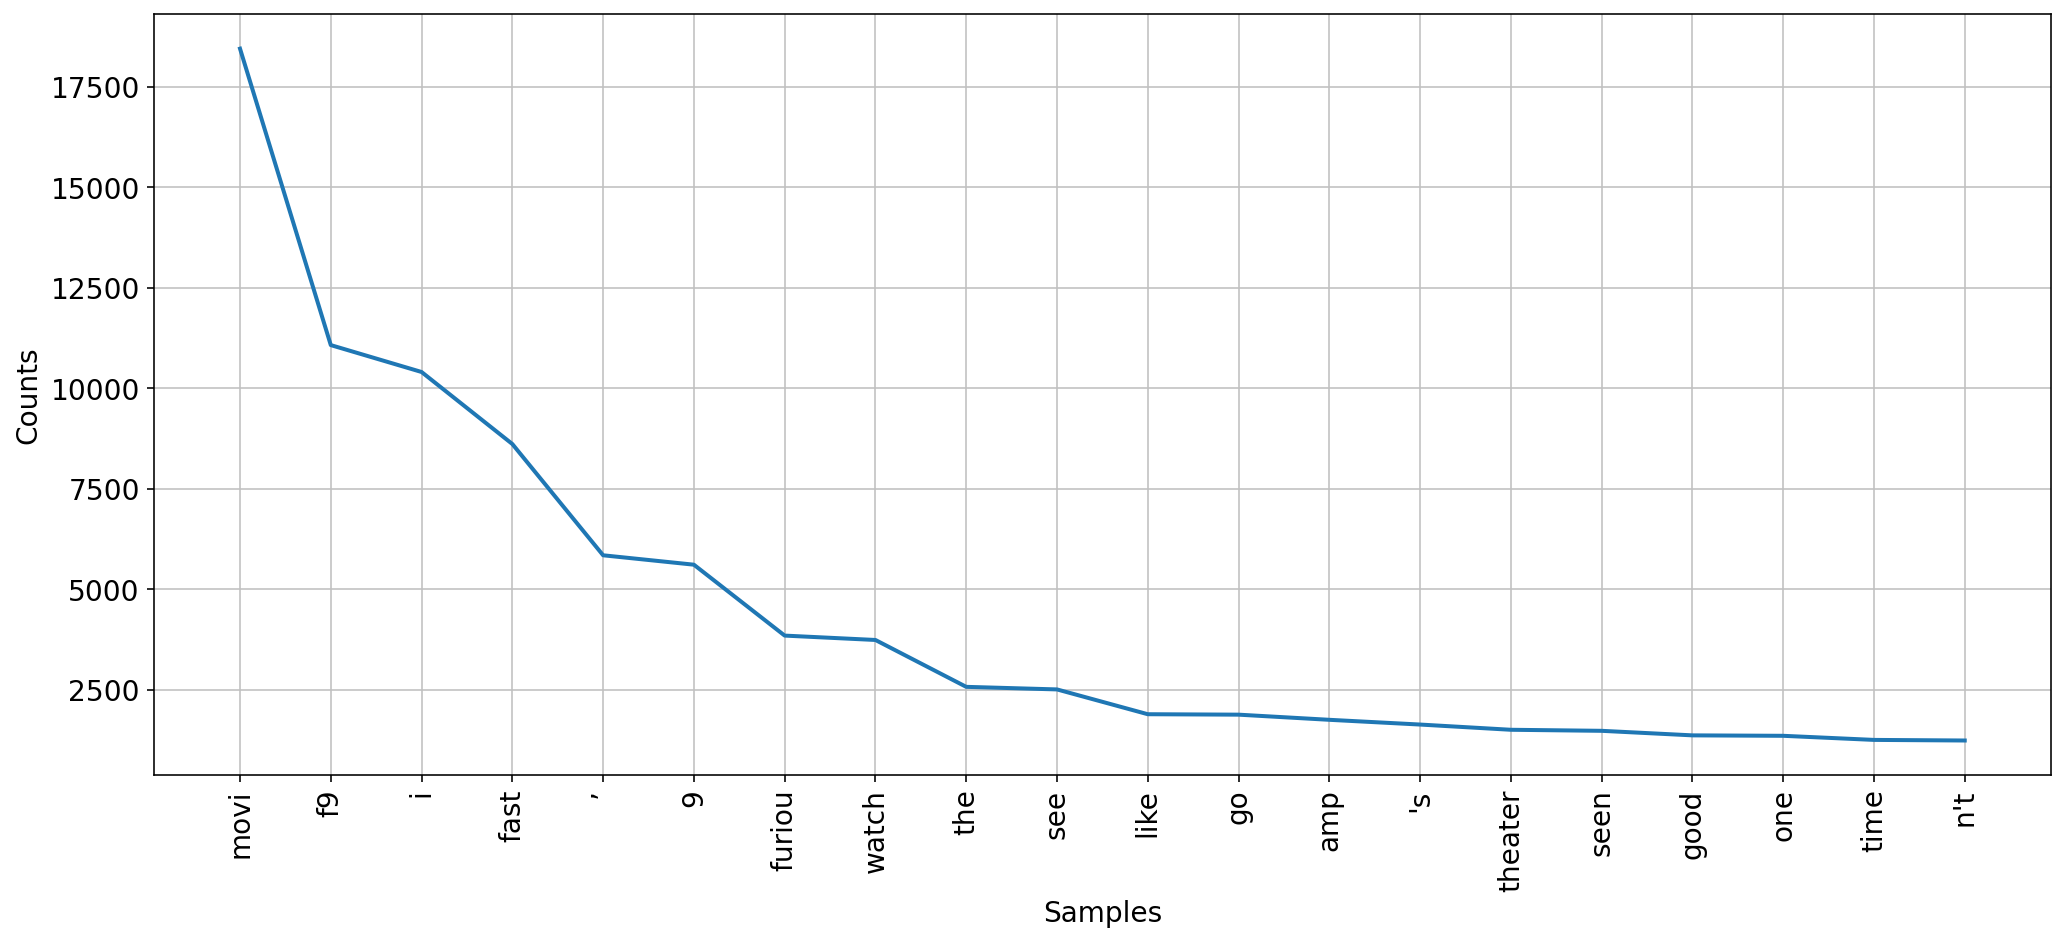

In [8]:
# get words after stemming
bw_tweets = tweets_df[tweets_df['movie'] == 'F9: The Fast Saga']
tweet_series = bw_tweets.squeeze()
tweet_stem = tweet_series['tweet_stem'].apply(pd.Series).stack()

from nltk.probability import FreqDist
import string

#calculate word frequency
fdist_tweets = FreqDist(tweet_stem)
#delete punctuation counts
for punc in string.punctuation:
    del fdist_tweets[punc]

#get top 20 words
fdist_tweets.plot(20, cumulative=False);

In [9]:
bw_tweets = tweets_df[tweets_df['movie'] == 'Black Widow']

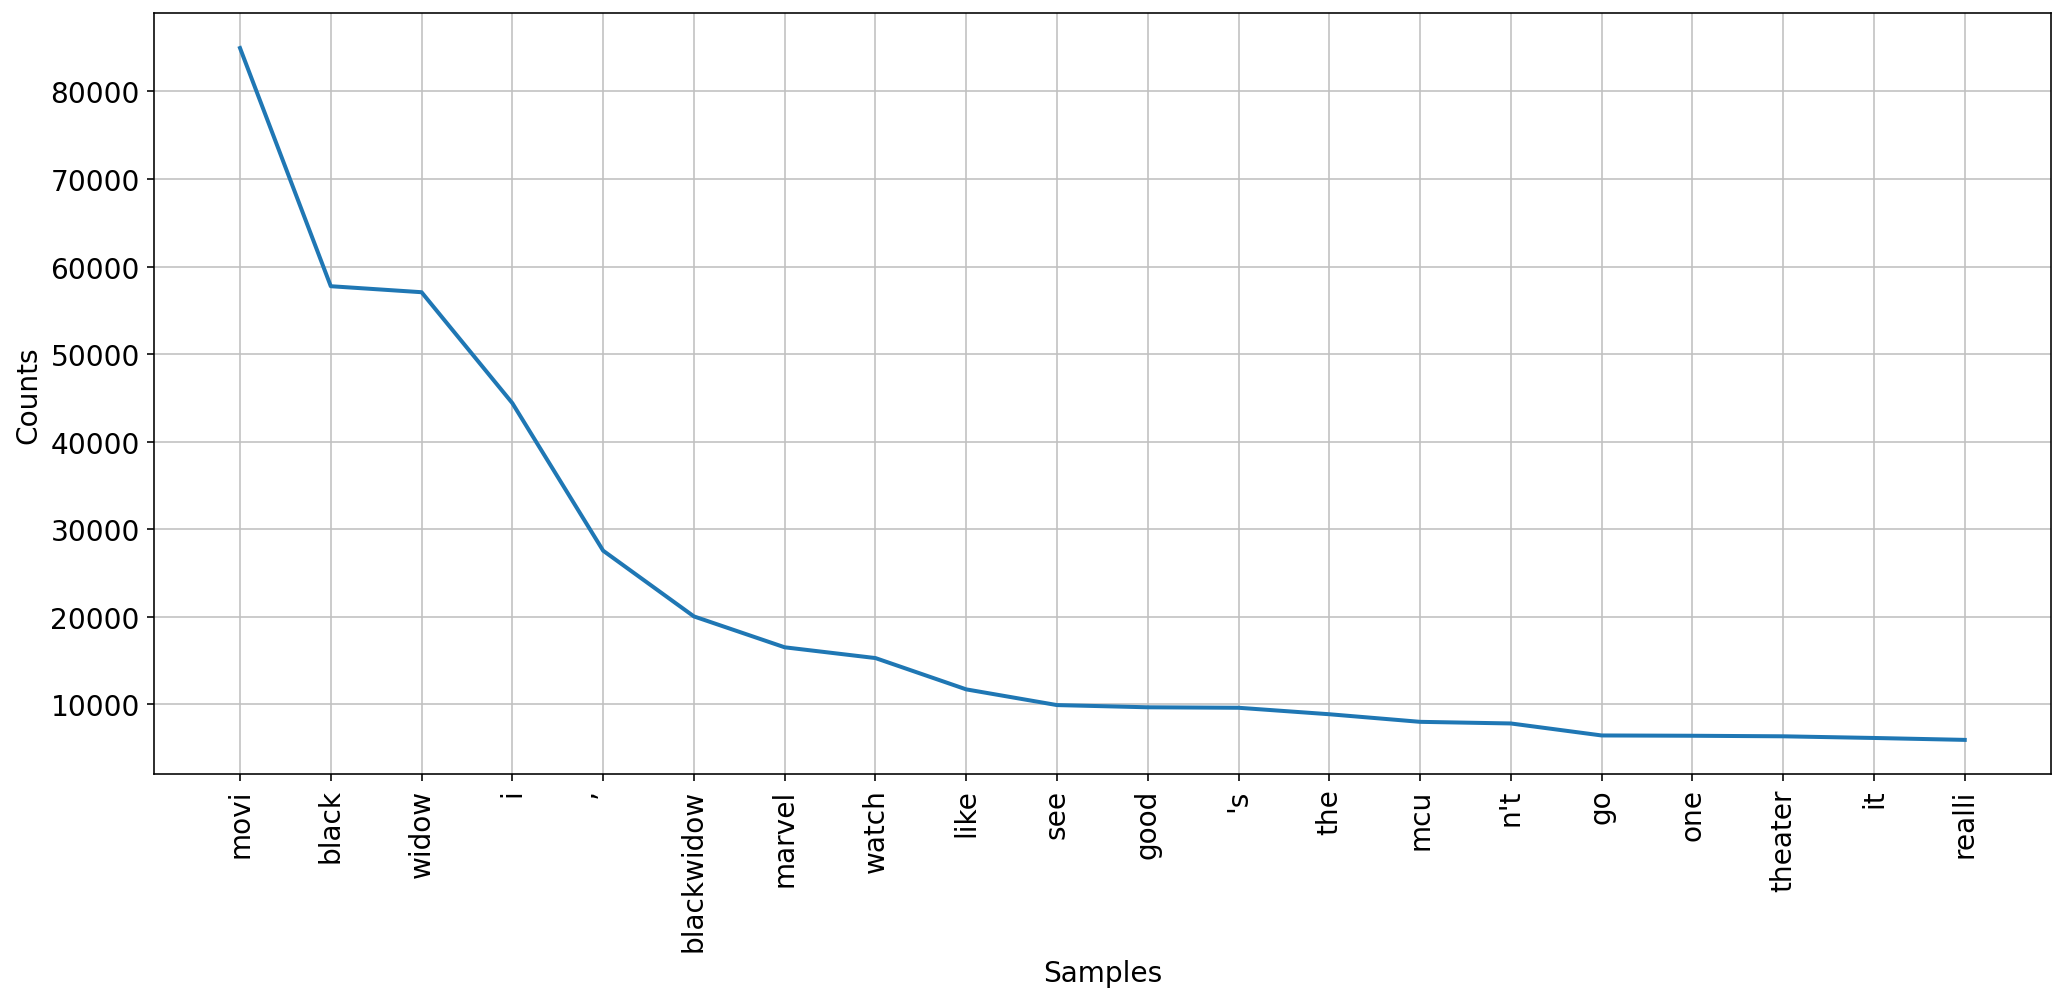

In [10]:
# get words after stemming
bw_tweets = tweets_df[tweets_df['movie'] == 'Black Widow']
tweet_series = bw_tweets.squeeze()
tweet_stem = tweet_series['tweet_stem'].apply(pd.Series).stack()

from nltk.probability import FreqDist
import string

#calculate word frequency
fdist_tweets = FreqDist(tweet_stem)
#delete punctuation counts
for punc in string.punctuation:
    del fdist_tweets[punc]

#get top 20 words
fdist_tweets.plot(20, cumulative=False);

In [11]:
# VADER sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyser = SentimentIntensityAnalyzer()
test_tweet = tweets_df.iloc[0]['tweet_clean']
print(test_tweet)
print(analyser.polarity_scores(test_tweet))

SpiderMan has saved the movie going experience!!!
{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.5684}


In [12]:
sentiment_df = pd.DataFrame()
sentiment_df['tweet_clean'] = tweets_df['tweet_clean']
sentiment_df['sentiment'] = tweets_df['tweet_clean'].apply(analyser.polarity_scores)
sentiment_df.head()

,tweet_clean,sentiment
0,SpiderMan has saved the movie going experience!!!,"{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compou..."
1,Yes- so good! Grab extra napkins with your pop...,"{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compou..."
2,“Spider Man trailer and stock prices”… Story |...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,too obsessed,"{'neg': 0.63, 'neu': 0.37, 'pos': 0.0, 'compou..."
4,Looking forward to Spider-Man tonight. If anyo...,"{'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compou..."


In [13]:
def spread_sentiment(sentiment_obj, category):
    return sentiment_obj[category]
sentiment_df['compound'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'compound'))
sentiment_df['neg'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'neg'))
sentiment_df['neu'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'neu'))
sentiment_df['pos'] = sentiment_df['sentiment'].apply(lambda x: spread_sentiment(x, 'pos'))
sentiment_df.drop(columns=['sentiment'], inplace=True)
sentiment_df.head()

,tweet_clean,compound,neg,neu,pos
0,SpiderMan has saved the movie going experience!!!,0.5684,0.00,0.62,0.38
1,Yes- so good! Grab extra napkins with your pop...,0.7339,0.00,0.66,0.34
2,“Spider Man trailer and stock prices”… Story |...,0.0000,0.00,1.00,0.00
3,too obsessed,-0.1779,0.63,0.37,0.00
4,Looking forward to Spider-Man tonight. If anyo...,-0.6875,0.25,0.75,0.00


In [14]:
# group by and mean compound scores
grouped = sentiment_df.groupby(by=['movie_id'])
mean_sentiment_df = grouped.mean()
mean_sentiment_df.head()

,tweet_clean,compound,neg,neu,pos,label
0,SpiderMan has saved the movie going experience!!!,0.5684,0.00,0.62,0.38,pos
1,Yes- so good! Grab extra napkins with your pop...,0.7339,0.00,0.66,0.34,pos
2,“Spider Man trailer and stock prices”… Story |...,0.0000,0.00,1.00,0.00,neu
3,too obsessed,-0.1779,0.63,0.37,0.00,neg
4,Looking forward to Spider-Man tonight. If anyo...,-0.6875,0.25,0.75,0.00,neg


In [15]:
# get number of tweets per movie
count_sentiment_df = grouped.count()
movie_aggregate_df = mean_sentiment_df.merge(count_sentiment_df['tweet_clean'], left_index=True, right_on='movie_id')
movie_aggregate_df.columns = ['compound_mean', 'neg_mean', 'neu_mean', 'pos_mean', 'num_tweets']
movie_aggregate_df.head(10)

before (801929, 6)
after (650046, 6)


In [ ]:
# join with box office
joined_df = movie_aggregate_df.merge(movies_df, left_on='movie_id', right_index=True)
joined_df.head(10)

In [ ]:
# Plot tweet counts
sorted_count_df = joined_df.sort_values(by='num_tweets', ascending=True)
sorted_count_plot = sns.barplot(data=sorted_count_df, y='num_tweets', x='movie')
for item in sorted_count_plot.get_xticklabels():
    item.set_rotation(90)

In [ ]:
# Describe num tweets
joined_df.describe()

We need to get rid of some outliers and low tweet counts to make our predictions more accurate.

In [ ]:
# To remove low count tweets for correlation, we will use movies with 1000
full_joined_df = joined_df
joined_df = joined_df[joined_df['num_tweets'] > 1000]

# Remove spider man
joined_df = joined_df[joined_df['num_tweets'] < 100000]
print(joined_df.shape)
print(joined_df.head())

sorted_count_df = joined_df.sort_values(by='num_tweets', ascending=True)
sorted_count_plot = sns.barplot(data=sorted_count_df, y='num_tweets', x='movie')
for item in sorted_count_plot.get_xticklabels():
    item.set_rotation(90)

### Connections between Average Compound Scores and Domestic Box Office

Let's see if there is a direct connection between average compound scores and domestic box office numbers

In [ ]:
def std_cash(string):
    string = string.replace('$','').replace(',','')
    return float(string)

correlation_df = pd.DataFrame()
correlation_df['compound'] = joined_df['compound_mean']
correlation_df['domestic'] = joined_df['domestic'].apply(std_cash)
correlation_df.head()

In [ ]:
sns.lmplot(x='compound', y='domestic', data=correlation_df, ci=None, aspect=1.8)

In [ ]:
outcome, predictors = patsy.dmatrices('domestic ~ compound', correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

#### Conclusion
There does not seem to be a direct correlation between average compound scores of tweets 2 months after release and domestic box office numbers. This is evident from the relatively high p value for our predictor number and low R squared, indicated that the pearson correlation number is low.

### Correlation Between Movie Tweet Count & Domestic Box Office

In [ ]:
correlation_df['num_tweets'] = joined_df['num_tweets']
correlation_df.head(10)

In [ ]:
sns.lmplot(x='num_tweets', y='domestic', data=correlation_df,
          ci=None, aspect=1.8)

In [ ]:
outcome, predictors = patsy.dmatrices('domestic ~ num_tweets', correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

#### Conclusion
There does seem to be a linear relationship between the number of tweets and domestic box office numbers. The p value for the predictor is low and the pearson coefficient squared seems to be high enough to suggest a positive correlation (R^2 = 0.25 -> R = 0.5). The OLS model suggests that for every tweet, box office numbers would increase by $1847.

Realistically, this makes some sense. Assuming it costs $10 for each movie ticket, $1847 would mean about 184 people bought tickets for the movie within the first 2 months. It is within the realm of possibility that only one out of 184 people would tweet about a movie they have seen.

### Correlation Between Tweet Count of Differing Sentiments & Domestic Box Office 

First we will add labels to our tweets (pos, neg, and neu). Then we will add up the number of labels per movie. Then we will see if there is a correlation between the number of labeled tweets.

In [ ]:
def compound_to_label(compound_score):
    if(compound_score >= 0.05): return 'pos'
    if(compound_score <= -0.05): return 'neg'
    return 'neu'

sentiment_df['label'] = sentiment_df['compound'].apply(compound_to_label)
sentiment_df.head(10)

In [ ]:
pos_df = sentiment_df[sentiment_df['label'] == 'pos']
neu_df = sentiment_df[sentiment_df['label'] == 'neu']
neg_df = sentiment_df[sentiment_df['label'] == 'neg']


pos_grouped = pos_df.groupby(by=['movie_id'])
pos_count = pos_grouped.count()['tweet_clean']
neu_grouped = neu_df.groupby(by=['movie_id'])
neu_count = neu_grouped.count()['tweet_clean']
neg_grouped = neg_df.groupby(by=['movie_id'])
neg_count = neg_grouped.count()['tweet_clean']
labeled_count_df = pd.DataFrame()
labeled_count_df['pos_count'] = pos_count
labeled_count_df['neu_count'] = neu_count
labeled_count_df['neg_count'] = neg_count
labeled_count_df['num_tweets'] = labeled_count_df['pos_count'] + labeled_count_df['neu_count'] + labeled_count_df['neg_count']

# Remove outliers and low tweet counts
labeled_count_df = labeled_count_df[labeled_count_df['num_tweets'] > 1000]
labeled_count_df = labeled_count_df[labeled_count_df['num_tweets'] < 100000]

# Add domestic
labeled_count_df['domestic'] = correlation_df['domestic']

labeled_count_df.head(10)

In [ ]:
# plot pos
sns.lmplot(x='pos_count', y='domestic', 
           data=labeled_count_df, ci=None, aspect=1.8)

In [ ]:
# plot neu
sns.lmplot(x='neu_count', y='domestic', 
           data=labeled_count_df, ci=None, aspect=1.8)

In [ ]:
# plot neg
sns.lmplot(x='neg_count', y='domestic', 
           data=labeled_count_df, ci=None, aspect=1.8)

### Notes
Just by looking at the graphs, the sentiments of the tweets do not matter as much as the more tweets generally equate to higher domestic box office numbers. We'll now use OLS to see how each of the labels correlate to the domestic numbers.

In [ ]:
outcome, predictors = patsy.dmatrices('domestic ~ pos_count + neu_count + neg_count', labeled_count_df)
model = sm.OLS(outcome, predictors)
pos_results = model.fit()

print(pos_results.summary())

### Notes
According to this OLS predictor, the amount of neutral

In [ ]:
outcome, predictors = patsy.dmatrices('domestic ~ compound + num_tweets + compound*num_tweets', correlation_df)
model = sm.OLS(outcome, predictors)
results = model.fit()

print(results.summary())